# ***Brain Tumor Analysis***
In this project we are going to predict wether if it is a **Brain Tumor** or not, using **Magnetic Resonance Imaging** *(MRI)*, from Kaggle.

## **Librarys**

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
import torchvision

## **Get Data**
Here we extract our data and give the right label to each image.

In [2]:
paht_yes = "brain_tumor_datasets/yes"
path_no = "brain_tumor_datasets/no"

images = []

def extract_images(folder, label):
    """
    Extracts file paths and labels for images stored in a given folder and appends them to a global list.

    Args:
        folder (str): Path to the folder containing image files.
        label (int/str): Label associated with all images in the folder.

    Returns:
        None: The function modifies a global list `data` by appending file paths and labels.
    """

    # Iterate through all files in the folder
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)  # Create the full file path
        
        # Check if the path points to a file
        if os.path.isfile(filepath): 
            images.append({"image": filepath, "label": label}) # Append the image path and label to `data`

extract_images(paht_yes, label=1)
extract_images(path_no, label=0)

data = pd.DataFrame(images)
data

,image,label
0,brain_tumor_datasets/yes\Y1.jpg,1
1,brain_tumor_datasets/yes\Y10.jpg,1
2,brain_tumor_datasets/yes\Y100.JPG,1
3,brain_tumor_datasets/yes\Y101.jpg,1
4,brain_tumor_datasets/yes\Y102.jpg,1
...,...,...
248,brain_tumor_datasets/no\No18.jpg,0
249,brain_tumor_datasets/no\No19.jpg,0
250,brain_tumor_datasets/no\No20.jpg,0
251,brain_tumor_datasets/no\No21.jpg,0


Here we used *os* and *pandas* libraries to create a dataframe and insert all the images by their labels. We firstly created 2 variables named *'path_yes'* and *'path_no'*, to append all the images that is or not a Tumor.

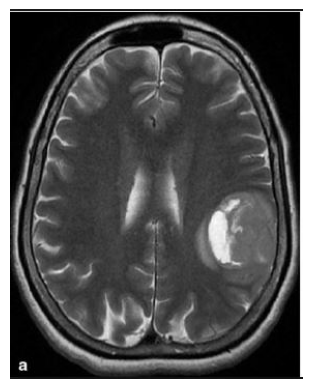

Cancer (1/0) -> 1


In [3]:
def get_image_by_pos(df: pd.DataFrame, image_feature, label_feature, pos: int):
    """
    Retrieves and displays an image from a dataset based on its position and prints its label.

    Args:
        df (pd.DataFrame): The DataFrame containing the dataset.
        image_feature (str): The column name in the DataFrame that contains the image file paths.
        label_feature (str): The column name in the DataFrame that contains the labels.
        pos (int): The index/position of the image to retrieve and display.

    Returns:
        None: Displays the image and prints the corresponding label.
    """

    img_path = df[image_feature][pos] # Get the image file path from the specified position

    img = Image.open(img_path) # Open the image file
    plt.imshow(img, cmap='gray') # Display the image in grayscale
    plt.axis('off') # Remove axis for better visualization
    plt.show()

    # Print the label corresponding to the image
    print(f"Cancer (1/0) -> {df[label_feature][pos]}")

get_image_by_pos(data, image_feature='image', label_feature='label', pos=154)

Just to check that the images were correctly appended, we created a function that receive the dataset, the name of the feature with all the images path, the label feature and the position that want to show, to return the image of the brain and if has cancer or not.
As we can see our images are extracted correclty.

### *Shuffle Dataset*

As we can see, our dataset has some complications, such as the data not being mixed up, in other words, the first images show those without cancer, while the following images show those with cancer. This is a problem because when we want to train the model and divid it into training, validation and test data, the model won't be able to lean the patterns of waht a 'cancer' is. For example, if we splt the dataset at the moment so that the first images are in the training data and the last images are in the test data, there's a huge chance that the model will only be able to learn from the images of the brain without cance, and that when ir comes to testing it will only pick up the images that have cancer. as a result, the model won't be able to learn any pattern and will only be able to predict images that don't have cancer. However, we'll mix up the data so that when we train the neural network, the model can learn all possible patterns.

In [4]:
data = data.sample(frac=1).reset_index(drop=True)

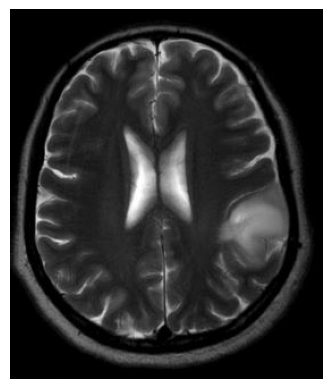

Cancer (1/0) -> 0


In [5]:
get_image_by_pos(data, image_feature='image', label_feature='label', pos=15)

As we can see now, our dataset has been shuffle correctly.

## **Exploratory Data Analysis (EDA) & Pre-Processing**
In this chapter, we will understand our data and make some changes if we think it needed.

For start, we will use bar chart to see if our data is balanced.

C:\Users\diogo\AppData\Local\Temp\ipykernel_5688\2387848494.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_feature, y='count', data=counts, palette='hls', ax=axes[0])


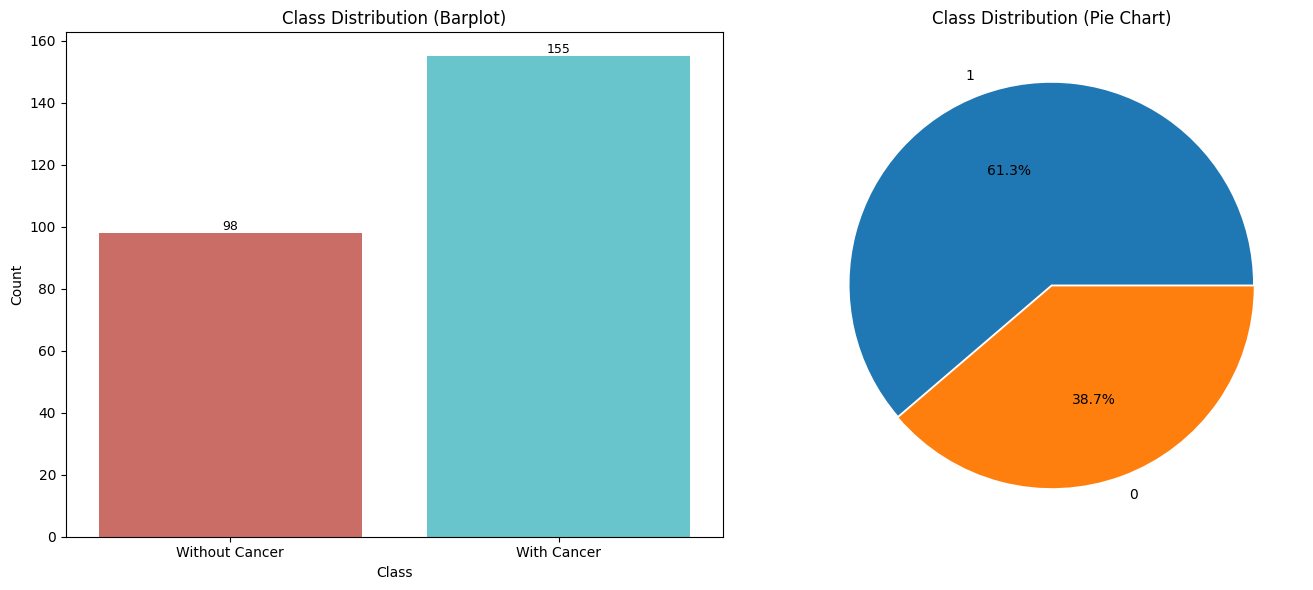

In [ ]:
def class_distribution_visualization(df: pd.DataFrame, label_feature: str):
    """
    Plots the distribution of classes in a dataset using a barplot and a pie chart.

    Args:
        df (pd.DatFrame): The dataset containing the labels.
        label_feature (str): The column name in the dataset that contains the class labels.
    
    Returns:
        None: Displays 2 graphs showing the distribution of classes.
    """
    counts = df[label_feature].value_counts().reset_index()
    counts.columns = [label_feature, 'count']

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.barplot(x=label_feature, y='count', data=counts, palette='hls', ax=axes[0])
    axes[0].bar_label(axes[0].containers[0], fontsize=9)
    axes[0].bar_label(axes[0].containers[1], fontsize=9)
    axes[0].set_title("Class Distribution (Barplot)")
    axes[0].set_xlabel("Class")
    axes[0].set_ylabel("Count")
    axes[0].set_xticks([0, 1])
    axes[0].set_xticklabels(["Without Cancer", "With Cancer"])

    labels = counts[label_feature].to_list()
    axes[1].pie(counts['count'], explode=(0.0, 0.01), labels=labels, autopct='%1.1f%%')
    axes[1].set_title("Class Distribution (Pie Chart)")

    plt.tight_layout()
    plt.show()


class_distribution_visualization(data, 'label')

These images show that the data is not unbalanced, but they do show that we don't have much data to work with. So it's best to use *Data Augmentation*.

***Data Augmentation*** is the process of making transformations to our data (rotations, translations) in order to increase our dataset.

However, a good practice would be to first split the data into training, validation and test, and apply these transformations only to the training data, so that the test and validation datasets don't receive any information from our training data.
## **Resize all the Images**
Before splitting the data, we'll resize them all to the same dimension and change the colours to black and white for al the images. This is a crucial step because Deep Learning models require inputs with fixed dimensions, and sice we're working with MRI, the colours of the images don't provide any valuable information. As this project focuses on building a Neural Networks from scratch, we have chosen images that are less computationally demanding. However, we will start by resizing the images to a smaller sizer (we will start with 224x224) and without colour. If we find that the computer can train with heavier images, we'll change the size of the images.

In [7]:
def check_shapes_from_path(df: pd.DataFrame, img_feature: str):
    """
    Checks and displays the number of unique image resolutions (shapes) in a dataset.

    Args:
        df (pd.DataFrame): A dataframe containing the dataset.
        img_feature (str): The column name in the DataFrame that holds the image data (as tensors or arrays)
    
    Returns:
        None: 
    """
    from collections import Counter

    # Get the Images from their path
    imgs_path = df[img_feature]
    imgs = [Image.open(img_path) for img_path in imgs_path]

    # Extract the shapes of all images in the dataset
    shapes = [img.size for img in imgs]

    # Count the occurrences of each shape
    shape_counts = Counter(shapes)

    # Display the results
    print(f"Number of shapes: {len(shape_counts)}")
    print(f"Shapes and their counts:")

    for shape, count in shape_counts.items():
        print(f"Shape: {shape} -> Count: {count}")

check_shapes_from_path(data, 'image')

Number of shapes: 184
Shapes and their counts:
Shape: (225, 225) -> Count: 18
Shape: (208, 242) -> Count: 2
Shape: (197, 255) -> Count: 1
Shape: (194, 259) -> Count: 1
Shape: (300, 325) -> Count: 4
Shape: (293, 337) -> Count: 1
Shape: (630, 630) -> Count: 10
Shape: (272, 350) -> Count: 2
Shape: (214, 236) -> Count: 1
Shape: (207, 243) -> Count: 1
Shape: (620, 620) -> Count: 2
Shape: (400, 431) -> Count: 2
Shape: (303, 354) -> Count: 1
Shape: (321, 352) -> Count: 1
Shape: (276, 326) -> Count: 1
Shape: (526, 555) -> Count: 1
Shape: (306, 365) -> Count: 1
Shape: (630, 614) -> Count: 1
Shape: (291, 340) -> Count: 1
Shape: (220, 275) -> Count: 2
Shape: (766, 879) -> Count: 1
Shape: (260, 331) -> Count: 1
Shape: (314, 340) -> Count: 2
Shape: (467, 586) -> Count: 1
Shape: (209, 212) -> Count: 1
Shape: (275, 301) -> Count: 1
Shape: (468, 444) -> Count: 1
Shape: (300, 168) -> Count: 3
Shape: (300, 353) -> Count: 1
Shape: (400, 369) -> Count: 1
Shape: (173, 201) -> Count: 2
Shape: (297, 348) -> 

In [8]:
def transform_data(df: pd.DataFrame, transform: torchvision.transforms.Compose):
    """
    Applies a transformation to a dataset of images and returns the transformed dataset.

    Args:
        dataset (pd.DataFrame): DataFrame containing image file paths in the first column and labels in the second column.
        transform (torchvision.transforms.Compose): Transformations to be applied to the images.

    Returns:
        pd.DataFrame: A DataFrame containing the transformed images as tensors and their corresponding labels.
    """

    images = [] # List to store transformed image tensors
    labels = [] # List to store labels

    # Iterate through each image path and label in the dataset
    for img_path, label in zip(df.iloc[:, 0], df.iloc[:, 1]):
        img = Image.open(img_path) # Open the image file

        transformed_img = transform(img) # Apply the transformation

        images.append(transformed_img) # Store the transformed image tensor
        labels.append(label) # Store the corresponding label

    # Create a new DataFrame with transformed images and labels
    transformed_df = pd.DataFrame({
        "Image": images,
        "Label": labels
    })

    return transformed_df


def check_shapes(df: pd.DataFrame, image_feature: str):
    """
    Visualizes the distribution of image resolutions (shapes) in a dataset.

    Args:
        df (pd.DataFrame): A DataFrame containing the dataset.
        img_feature (str): The column name in the DataFrame that holds the image data (as tensors or arrays).
    
    Returns:
        None: Displays a bar plot showing the frequency of each image resolution.
    """
    from collections import Counter

    # Extract the shapes of all images in the dataset
    shapes = [img.shape for img in df[image_feature]]

    # Count the occurrences of each shape and print it
    shape_count = Counter(shapes)
    print(f"Number of Shapes: {len(shape_count)}")

    # Plot a bar chart
    pd.Series(shape_count).plot(kind='bar', title='Resolution Distribution')
    plt.xlabel('Shape')
    plt.ylabel('Count')

    plt.show()



In [9]:
transform = v2.Compose([
        v2.Grayscale(num_output_channels=1),
        v2.ToTensor(),
        v2.Resize((224, 224))
    ])

transformed_dataframe = transform_data(data, transform)
transformed_dataframe.shape

c:\Users\diogo\miniconda3\envs\deep-learning\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


(253, 2)

Number of Shapes: 1


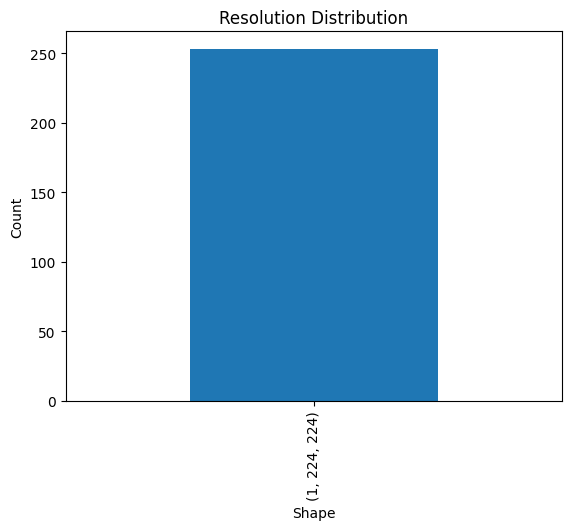

In [10]:
check_shapes(transformed_dataframe, 'Image')

The image shows that our function worked well, since our images are all in the same size.
### *Split Data*
So that we use the techniques only for training dataset, we will split our data before all the *EDA* and *Pre-Processing*.

In [11]:
train_df, val_test_df = train_test_split(transformed_dataframe, test_size=0.6, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

In [12]:
train_df.shape, val_df.shape, test_df.shape

((101, 2), (76, 2), (76, 2))

Now that we got our data splitted, let's go to the next step.

### *Data Augmentation*

In [15]:
def train_augmentation(df: pd.DataFrame, transform: torchvision.transforms.Compose, num_augmentations=1) -> pd.DataFrame: 
    """
    Augments a dataset by applying transformations to each image.

    Args:
        df (pd.DataFrame): Training DataFrame containing images and their labels.
        transform (torchvision.transforms.Compose): Transformations to apply to the images.
        num_augmentations (int): Number of augmented versions to generate for each image.

    Returns:
        pd.DataFrame: A new DataFrame containing both original and augmented images with their corresponding labels.
    """

    images = []
    labels = []

    # Iterate through the dataset to process each image and label
    for image, label in zip(df.iloc[:, 0], df.iloc[:, 1]):
        # Add the original image and label
        images.append(image)
        labels.append(label)

        # Apply transformations to create augmented images
        for _ in range(num_augmentations):
            transform_img = transform(image)
            images.append(transform_img)
            labels.append(label)
    
    # Create a new DataFrame with augmented images and labels
    augmented_dataframe = pd.DataFrame({
        "Images": images,
        "Labels": labels
    })

    return augmented_dataframe


def show_images_by_class(df: pd.DataFrame, label, n=5):
    """
    Displays a sample of images from a specific class.

    Args:
        df (pd.DataFrame): DataFrame containing images and labels
        label (int): The class label to filter the images by.
        n (int): Number of images to display

    Returns:
        None: Displays the images in a matplotlib plot.
    """

    # Filter the DataFrame to include only rows with the specified class label
    filtered = df[df.iloc[:, 1] == label]

    # Randomly sample 'n' images from the filtered DataFrame
    sampled = filtered.sample(n)

    # Create a figure with 'n' subplots for displaying images
    fig, axes = plt.subplots(1, n, figsize=(15, 5))

    # Iterate through the sampled images and display them
    for i, (img, lbl) in enumerate(zip(sampled.iloc[:, 0], sampled.iloc[:, 1])):
        # Display the image
        axes[i].imshow(img.numpy().squeeze(), cmap='gray')
        axes[i].set_title(f"Class {lbl}") # Set the title to show the class label
        axes[i].axis('off') # Turn off axis labels

    plt.show()


def compare_original_transformed(df: pd.DataFrame, transform: torchvision.transforms.Compose, num_samples=5):
    """
    Compares original images with their transformed versions side by side.

    Args:
        dataset (pd.DataFrame): DataFrame containing images and labels.
        transform (torchvision.transforms.Compose): Transformations to apply to the images.
        num_samples (int): Number of image samples to compare.

    Returns:
        None: Displays a matplotlib plot with the original and transformed images.
    """
    # Randomly sample 'num_samples' images from the dataset
    sampled_data = df.sample(num_samples)
    
    # Create a figure with `num_samples` rows and 2 columns (original and transformed)
    fig, axes = plt.subplots(num_samples, 2)

    # Iterate through the sampled images
    for i, (original_img, label) in enumerate(zip(sampled_data.iloc[:, 0], sampled_data.iloc[:, 1])):
        # Apply transformations to the original image
        transformed_img = transform(original_img)

        # Display the original image in the left column
        axes[i, 0].imshow(original_img.numpy().squeeze(), cmap='gray')
        axes[i, 0].set_title(f"Original (Label: {label})")
        axes[i, 0].axis('off')

        # Display the transformed image in the right column
        axes[i, 1].imshow(transformed_img.numpy().squeeze(), cmap='gray')
        axes[i, 1].set_title("Transformed")
        axes[i, 1].axis('off')

    # Add a title to the entire figure
    plt.suptitle("Comparison of Original and Transformed Images", fontsize=16)
    plt.tight_layout() # Adjust the layout to prevent overlapping
    plt.show()

In [20]:
train_transform = v2.Compose([
    v2.Resize((224, 224), antialias=True),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(degrees=30),
    v2.RandomCrop(200),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5], std=[0.5])
])

train_augmented = train_augmentation(train_df, train_transform, num_augmentations=3)
train_augmented.shape

(404, 2)

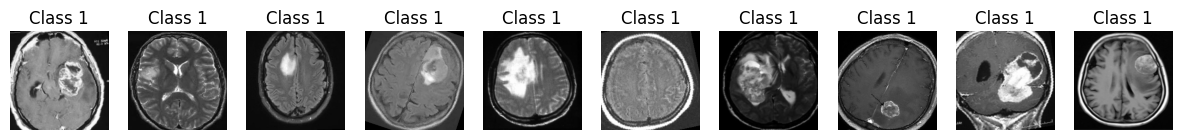

In [17]:
show_images_by_class(train_augmented, label=1, n=10)

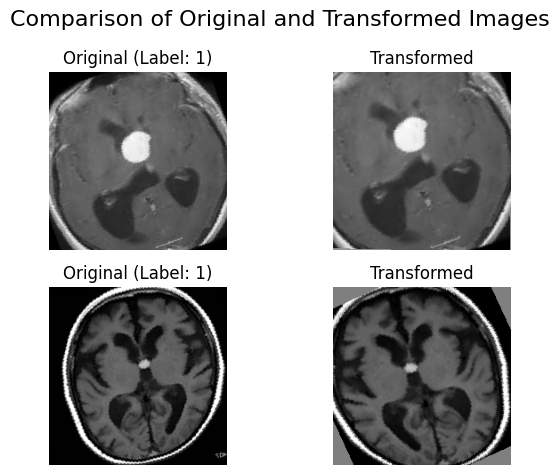

In [18]:
compare_original_transformed(train_augmented, transform=train_transform, num_samples=2)

In [21]:
train_augmented.shape, val_df.shape, test_df.shape

((404, 2), (76, 2), (76, 2))

The images show that the data augmentation was succesful, so let's check again the chart to the new data.

C:\Users\diogo\AppData\Local\Temp\ipykernel_5688\2387848494.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_feature, y='count', data=counts, palette='hls', ax=axes[0])


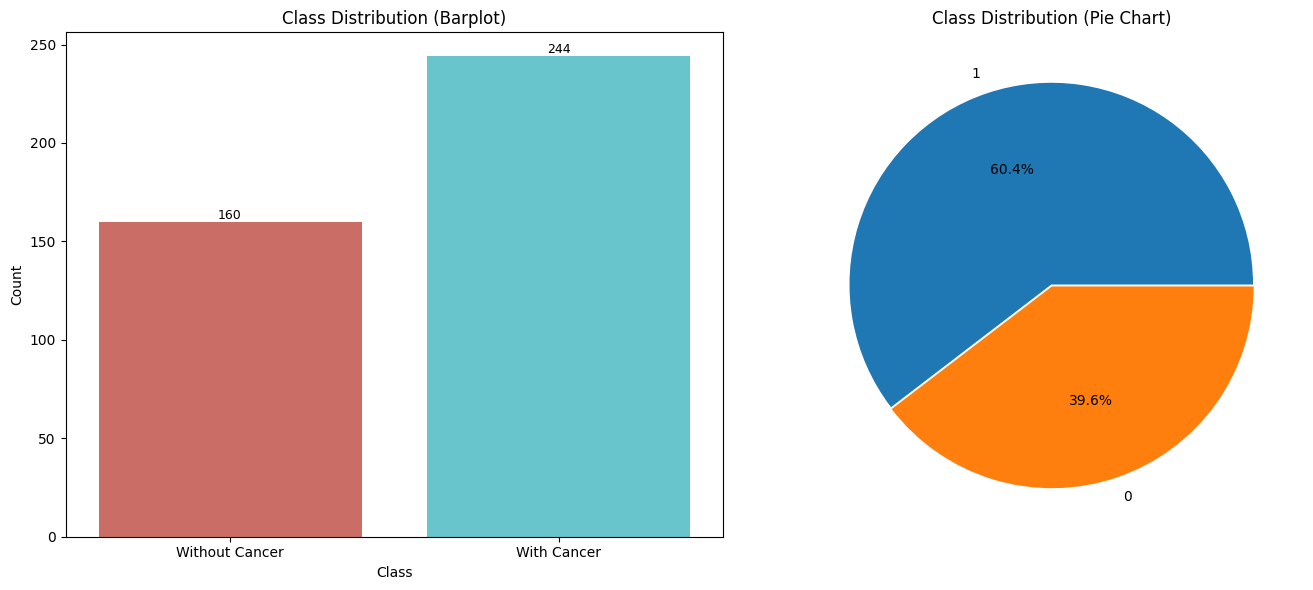

In [22]:
class_distribution_visualization(train_augmented, 'Labels')

As it can be seen through the images, our training dataset has increased exponentially.